In [129]:
from PIL import Image
from wand.image import Image as wandImage
from wand.color import Color
import cv2
import PyPDF2
import pytesseract
import argparse
import os
import io
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tempfile
import mrjob
import pickle
%matplotlib inline
plt.rcParams["figure.figsize"] = (50,30)

In [65]:
def pdf_page_to_img(src_pdf, pagenum, resolution=300, preprocess="thresh"):

#    src_pdf = PyPDF2.PdfFileReader(filename)
    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(src_pdf.getPage(pagenum))
    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)
    img_buffer=None

    with wandImage(file = pdf_bytes, resolution = resolution) as img:
        img.format = "png"
        img.alpha_channel = False
        img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

    if img_buffer is not None:
        retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if preprocess == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    elif preprocess == "blur":
        gray = cv2.medianBlur(gray, 3)

    return Image.fromarray(gray)

In [31]:
def ocr(image, verbose=True, debug=False):
    # load the image as a PIL/Pillow image, apply OCR
    pagecontents = {}
    data = pytesseract.image_to_data(image, output_type="df.frame")
    boxes = pytesseract.image_to_boxes(image)
    try:
        df = pd.read_csv(io.StringIO(data), sep="\t", quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python')
        dfm = df.loc[(list(map(lambda x: str(x).strip()!='', df['text'])) & (df['conf']> -1) & (df['text']).notnull())]
        df = dfm.set_index(["block_num","par_num"])
        blockstats = {'block':[], 'n_par':[], 'n_line':[], 'top_at':[], 'bottom_at':[], 'left_at':[], 'right_at':[]}
        paragraphs = {}
        for block in df.index.levels[0]:
            blockstats['block'].append(block)
            blockstats['n_par'].append(len(np.unique(df.loc[block,].index.values)))
            blockstats['n_line'].append(df.loc[(block,)]['top'].count())
            blockstats['top_at'].append(min(df.loc[(block,)]['top']))
            blockstats['bottom_at'].append(max(df.loc[(block,)]['top']+df.loc[(block,)]['height']))
            blockstats['left_at'].append(min(df.loc[(block,)]['left']))
            blockstats['right_at'].append(max(df.loc[(block,)]['left']+df.loc[(block,)]['width']))
            paragraphs[block] = []
            for i in df.loc[block].index.unique():
                paragraphs[block].append(' '.join(list(map(lambda x: x.strip(), df.loc[block].loc[i,'text']))))
        blockstats = pd.DataFrame(data=blockstats).set_index('block')
        pagecontents['blockstats'] = blockstats
        pagecontents['paragraphs'] = paragraphs
    except:
        print("exception")

    if debug == True:
        tmp = tempfile.mkstemp(suffix='.png', prefix='tmp', dir=None, text=False)
        imgfilename = tmp[1]
        print(imgfilename)
        pagecontents['filename'] = imgfilename
        image.save(imgfilename)
       
    if verbose == True:
        pagecontents['data'] = dfm
        pagecontents['boxes'] = pd.read_csv(io.StringIO(boxes), quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python',
                                            sep="\s", header=None, names=["character", "x1","y1","x2","y2","c"])

    return pagecontents


In [101]:
def showpage(all_pages, pagenum):

    page = wandImage(all_pages.sequence[pagenum])
    with page as img:
        img.format = 'png'
        image_filename = 'temp.png'
        img.save(filename=image_filename)

        image = cv2.imread(image_filename)

    plt.rcParams["figure.figsize"] = (50,30)
    
    blockstats = pagecontents[pagenum]['blockstats']

    # draw the bounding boxes on the image
    h, w = gray.shape
    img_blocks = image.copy()
    for index, row in blockstats.iterrows():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

    # show the output image with block bounding boxes
    plt.imshow(img_blocks,cmap='gray')
    plt.show()
    
    return True

In [50]:
args = {"filename": "1863Langley/1863Langley.pdf", "pagenum": 360, "resolution": 300, "preprocess": "thresh"}

src_pdf = PyPDF2.PdfFileReader(args["filename"])
num_pages = src_pdf.getNumPages()

page_range = range(0, num_pages)
pagecontents = {}
for pagenum in page_range:
    print(pagenum)
    pagecontents[pagenum] = ocr(pdf_page_to_img(src_pdf, pagenum, args['resolution'], args['preprocess']))
    
pickle.dump( pagecontents, open( "Langley1863.p", "wb" ) )
# pageimages = wandImage(filename=args["filename"], resolution=args['resolution'])
# pagecontents = pickle.load(open( "Langley1863.p", "rb" ) )
# wandImage(pageimages.sequence[81])

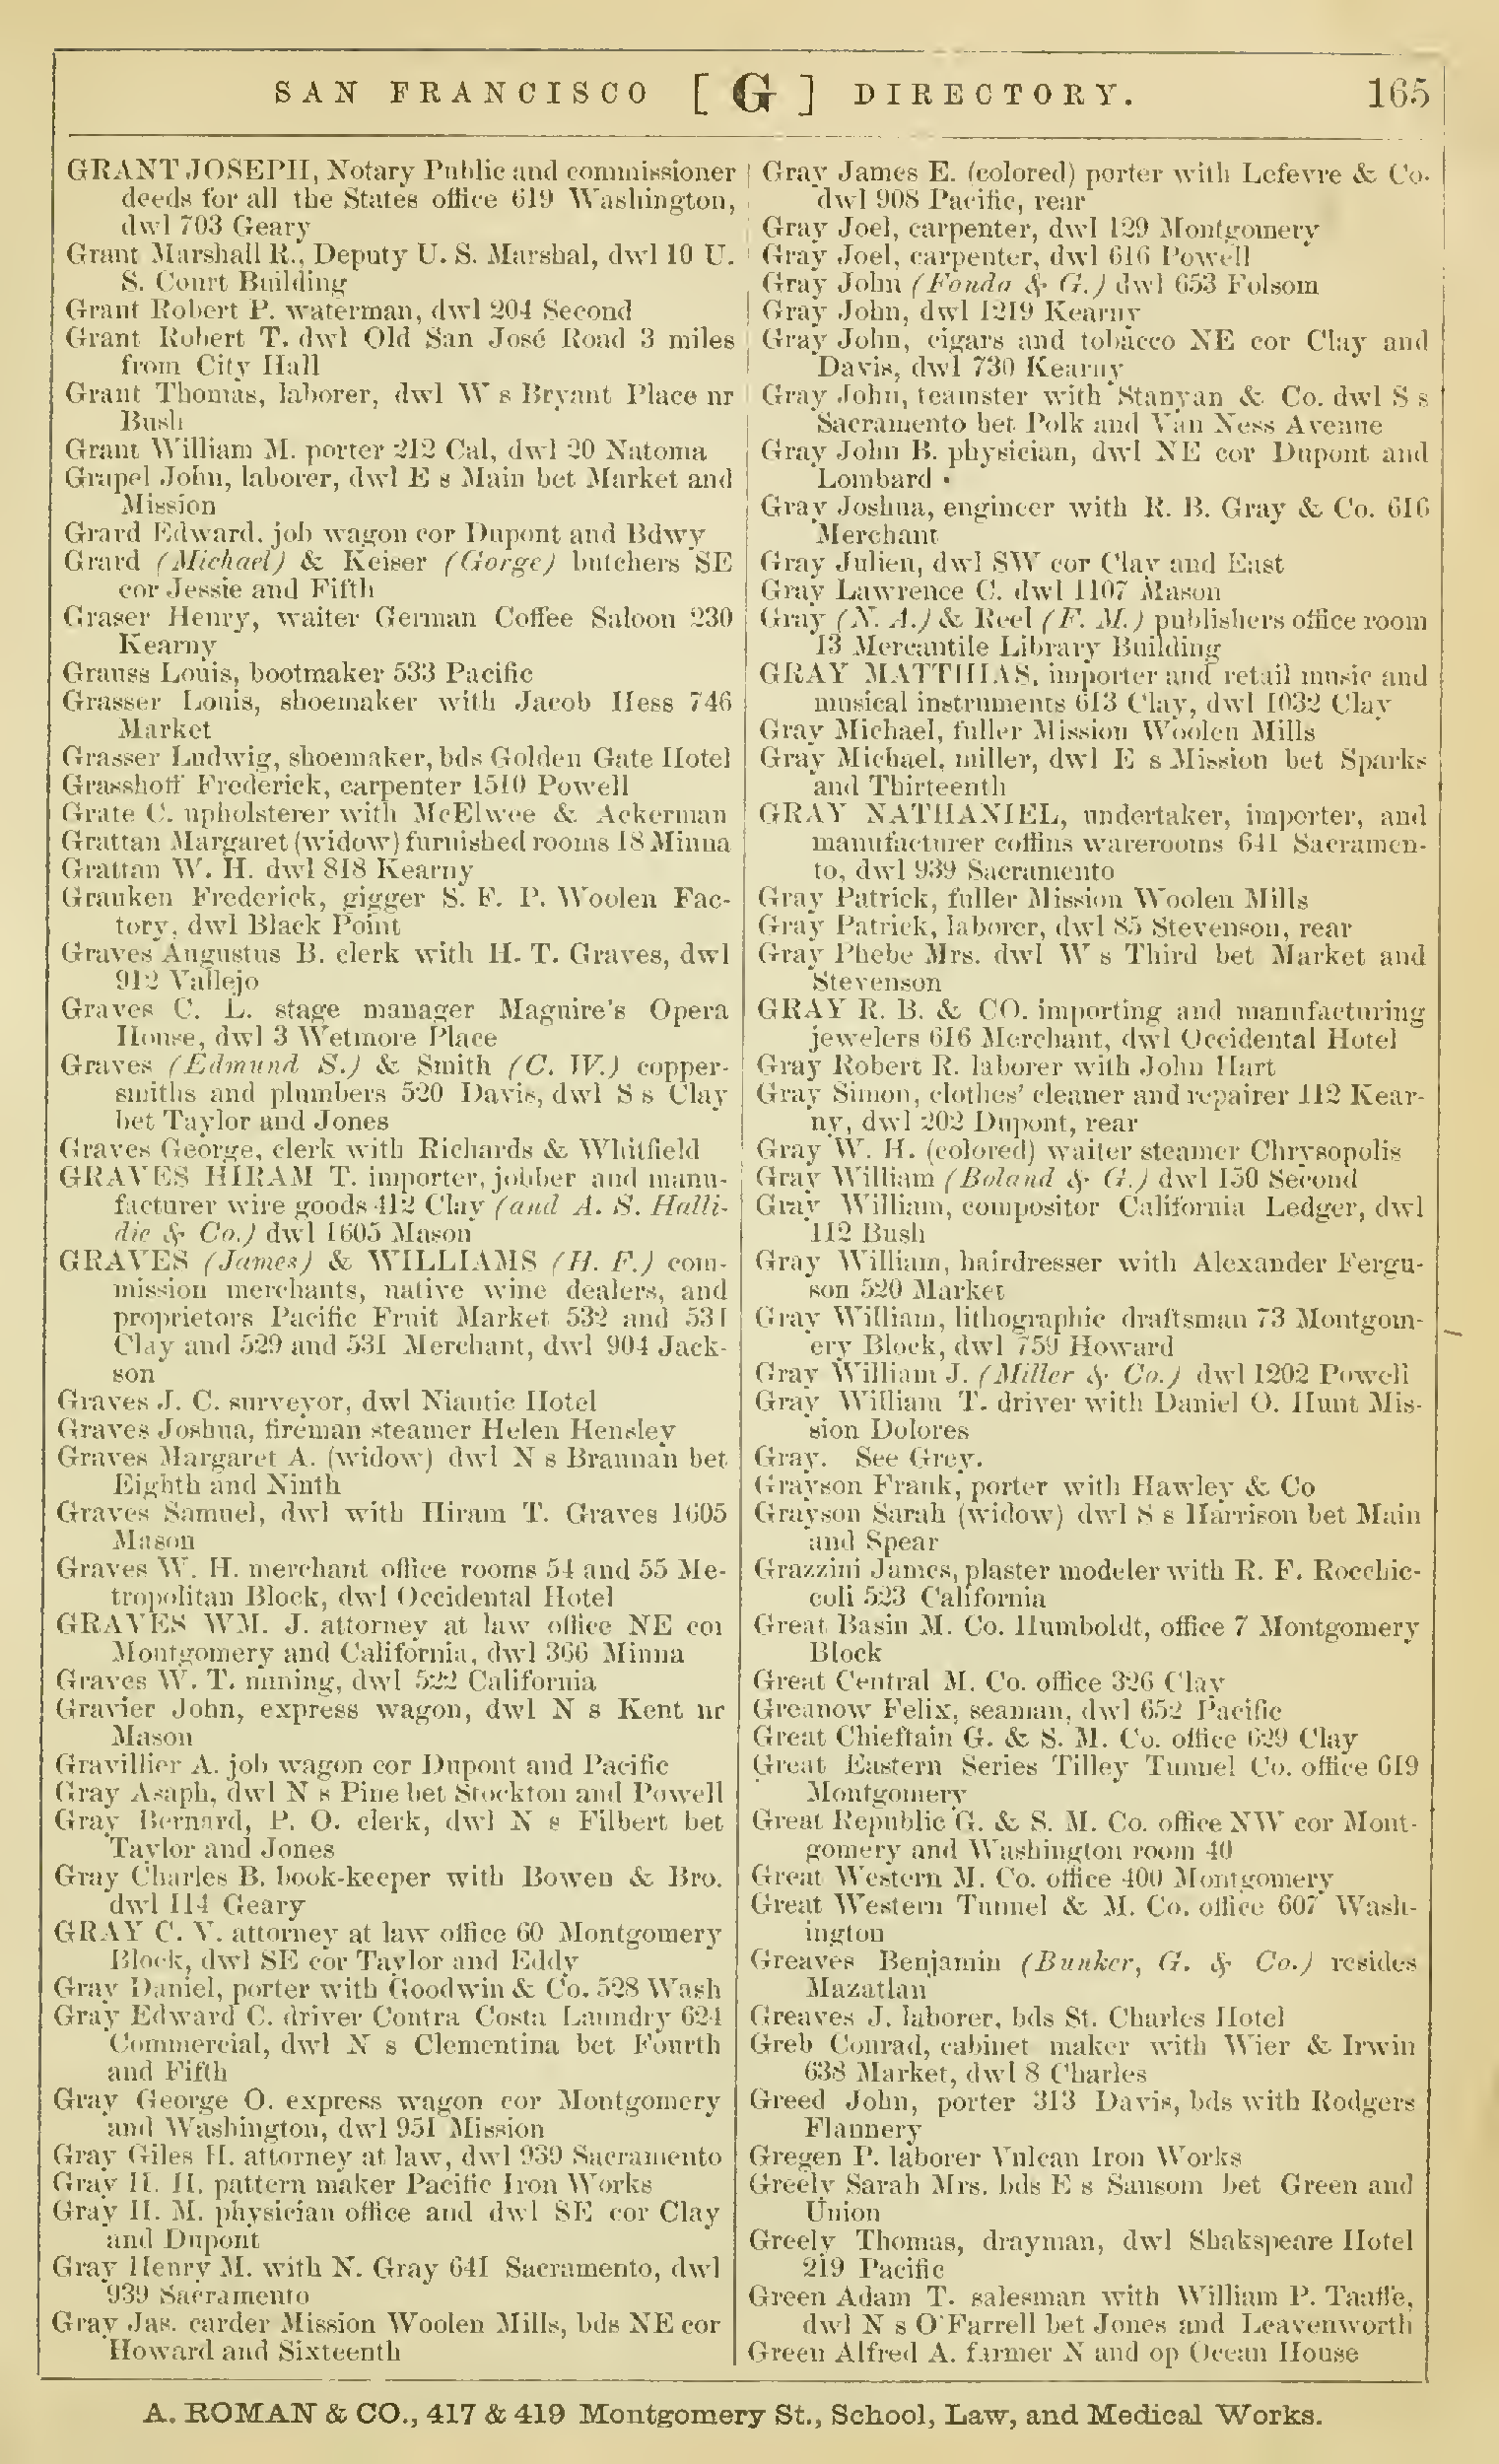

In [116]:
# pageimages = wandImage(filename=args["filename"], resolution=args['resolution'])
wandImage(pageimages.sequence[250])

In [98]:
pagenum = 250

with wandImage(pageimages.sequence[pagenum]) as img:
    img.format = "png"
    img.alpha_channel = False
    img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

if img_buffer is not None:
    retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#if preprocess == "thresh":
gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

#elif preprocess == "blur":
#    gray = cv2.medianBlur(gray, 3)

blockstats = pagecontents[pagenum]['blockstats']

h, w = gray.shape
img_blocks = gray.copy()
for index, row in blockstats.iterrows():
    top_left = (row['left_at'], row['top_at'])
    bottom_right = (row['right_at'], row['bottom_at'])
    img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

# show the output image with block bounding boxes
#plt.imshow(img_blocks,cmap='gray')
plt.show()

TypeError: First argument must be a path or file object reading bytes

<Figure size 3600x2160 with 1 Axes>

In [127]:
h, w = gray.shape
img_blocks = gray.copy()
for index, row in blockstats.iterrows():
    top_left = (row['left_at'], row['top_at'])
    bottom_right = (row['right_at'], row['bottom_at'])
    img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)
plt.imshow(img_blocks,cmap='gray')


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x128fe2ea0> (for post_execute):


TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

<Figure size 3600x2160 with 1 Axes>

In [134]:
type(pageimages)

wand.image.Image

In [118]:
with wandImage(pageimages.sequence[pagenum]) as img:
    img.format = "png"
    img.alpha_channel = False
    img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)
if img_buffer is not None:
    retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]